In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
import zipfile

# Paso 0: Descargar y extraer MovieLens 1M
!wget --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o ml-1m.zip

--2025-08-15 03:08:04--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  13.0MB/s    in 0.4s    

2025-08-15 03:08:04 (13.0 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [ ]:
# Paso 1: Cargar ratings
df = pd.read_csv("ml-1m/ratings.dat", sep="::", engine='python',
                 names=["user_id", "item_id", "rating", "timestamp"])

In [ ]:
# Paso 5: Dataloaders
batch_size = 512  # más grande para aprovechar volumen
train_dataset = RatingsDataset(train_df)
test_dataset = RatingsDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
class NeuralMF(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim=32):
        super(NeuralMF, self).__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(32, 1)

    def forward(self, user_ids, item_ids):
        user_vecs = self.user_embedding(user_ids)
        item_vecs = self.item_embedding(item_ids)
        x = torch.cat([user_vecs, item_vecs], dim=1)
        x = self.fc_layers(x)
        return self.output_layer(x).squeeze()


Época 1/20 | Train Loss: 1.2664 | Test Loss: 0.9397
Época 2/20 | Train Loss: 0.8829 | Test Loss: 0.8746
Época 3/20 | Train Loss: 0.8385 | Test Loss: 0.8570
Época 4/20 | Train Loss: 0.8223 | Test Loss: 0.8487
Época 5/20 | Train Loss: 0.8126 | Test Loss: 0.8472
Época 6/20 | Train Loss: 0.8062 | Test Loss: 0.8456
Época 7/20 | Train Loss: 0.8005 | Test Loss: 0.8467
Época 8/20 | Train Loss: 0.7952 | Test Loss: 0.8468
Época 9/20 | Train Loss: 0.7907 | Test Loss: 0.8487
Época 10/20 | Train Loss: 0.7863 | Test Loss: 0.8469
Época 11/20 | Train Loss: 0.7814 | Test Loss: 0.8437
Época 12/20 | Train Loss: 0.7767 | Test Loss: 0.8439
Época 13/20 | Train Loss: 0.7722 | Test Loss: 0.8448
Época 14/20 | Train Loss: 0.7678 | Test Loss: 0.8463
Época 15/20 | Train Loss: 0.7629 | Test Loss: 0.8473
Época 16/20 | Train Loss: 0.7585 | Test Loss: 0.8486
Época 17/20 | Train Loss: 0.7536 | Test Loss: 0.8513
Época 18/20 | Train Loss: 0.7491 | Test Loss: 0.8519
Época 19/20 | Train Loss: 0.7444 | Test Loss: 0.8544
Ép

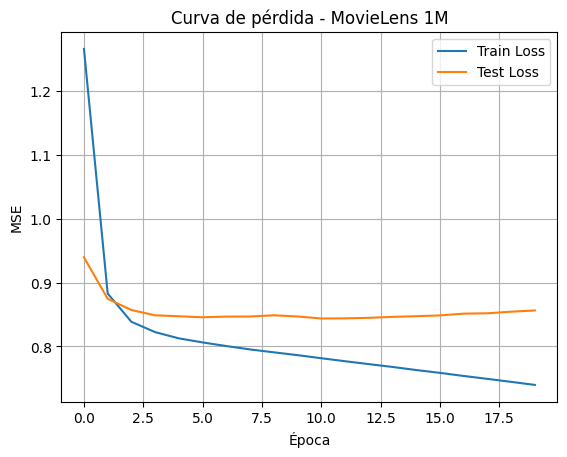

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

model = NeuralMF(n_users=n_users, n_items=n_items).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 20
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0

    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        optimizer.zero_grad()
        outputs = model(users, items)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(ratings)

    train_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for users, items, ratings in test_loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            outputs = model(users, items)
            loss = criterion(outputs, ratings)
            test_loss += loss.item() * len(ratings)

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

    print(f"Época {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.title('Curva de pérdida - MovieLens 1M')
plt.legend()
plt.grid(True)
plt.show()


### Evaluate the model

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    total_loss = 0.0
    for users, items, ratings in test_dataloader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        outputs = model(users, items)
        loss = criterion(outputs, ratings)
        total_loss += loss.item() * len(ratings)

    avg_test_loss = total_loss / len(test_dataloader.dataset)
    print(f"Average Test Loss (MSE): {avg_test_loss:.4f}")

Average Test Loss (MSE): 0.8563


### Generate recommendations for a user

In [ ]:
# Paso 1: Seleccionar un usuario de ejemplo
user_id_example = 15  # puedes cambiar este número según prefieras
# Convert user_id to the internal index
user_idx_example = user2idx[user_id_example]

# Paso 2: Obtener películas que ya ha calificado (usando el índice interno)
seen_items_idx = set(train_df[train_df['user'] == user_idx_example]['item'].tolist())

# Paso 3: Construir lista de ítems no vistos (usando el índice interno)
all_items_idx = set(range(n_items))
unseen_items_idx = torch.tensor(list(all_items_idx - seen_items_idx), dtype=torch.long).to(device)
user_tensor_unseen = torch.tensor([user_idx_example] * len(unseen_items_idx), dtype=torch.long).to(device)

# Paso 4: Predecir los ratings para ítems no vistos
model.eval()
with torch.no_grad():
    predictions = model(user_tensor_unseen, unseen_items_idx)

# Paso 5: Obtener el Top-N recomendaciones
top_N = 10
top_indices = torch.topk(predictions, top_N).indices
top_item_indices = unseen_items_idx[top_indices].cpu().numpy()

# Paso 6: Mostrar resultados
# Cargar metadata de películas para mostrar nombres
movies_df = pd.read_csv('ml-1m/movies.dat', sep="::", engine='python', names=["item_id", "title", "genres"], encoding='latin-1')
itemid2title = dict(zip(movies_df['item_id'], movies_df['title']))

print(f"Recomendaciones para el usuario {user_id_example}:")
for idx in top_item_indices:
    # Convert internal item index back to original item_id
    movie_id = idx2item[idx]
    print(f"- {itemid2title[movie_id]}")

Recomendaciones para el usuario 15:
- Gate of Heavenly Peace, The (1995)
- Mamma Roma (1962)
- Time of the Gypsies (Dom za vesanje) (1989)
- Apple, The (Sib) (1998)
- Grand Illusion (Grande illusion, La) (1937)
- Man of the Century (1999)
- Schlafes Bruder (Brother of Sleep) (1995)
- Third Man, The (1949)
- Raining Stones (1993)
- I Am Cuba (Soy Cuba/Ya Kuba) (1964)


In [ ]:
from tqdm import tqdm
import heapq
import math

def hit_and_ndcg_at_k(model, test_df, K=10, num_negatives=99):
    hits = []
    ndcgs = []

    model.eval()

    for user_id in tqdm(test_df['user'].unique()):
        # 1. Positivo real (elegimos uno del test set)
        real_items = test_df[test_df['user'] == user_id]['item'].values
        if len(real_items) == 0:
            continue
        positive_item = real_items[0]

        # 2. Negativos simulados (ítems que no ha calificado)
        negatives = list(set(range(n_items)) - set(train_df[train_df['user'] == user_id]['item']))
        if len(negatives) < num_negatives:
            continue
        negative_sample = np.random.choice(negatives, num_negatives, replace=False).tolist()

        # 3. Crear set de predicción
        item_candidates = negative_sample + [positive_item]
        user_tensor = torch.tensor([user_id] * len(item_candidates)).to(device)
        item_tensor = torch.tensor(item_candidates).to(device)

        with torch.no_grad():
            predictions = model(user_tensor, item_tensor).cpu().numpy()

        # 4. Ordenar por predicción
        item_score = {item: score for item, score in zip(item_candidates, predictions)}
        top_k_items = heapq.nlargest(K, item_score, key=item_score.get)

        # 5. Métricas
        hit = int(positive_item in top_k_items)
        hits.append(hit)

        if positive_item in top_k_items:
            index = top_k_items.index(positive_item)
            ndcg = math.log(2) / math.log(index + 2)
            ndcgs.append(ndcg)
        else:
            ndcgs.append(0.0)

    return np.mean(hits), np.mean(ndcgs)


In [ ]:
hit, ndcg = hit_and_ndcg_at_k(model, test_df, K=10)
print(f"Hit Rate@10: {hit:.4f}")
print(f"NDCG@10: {ndcg:.4f}")


100%|██████████| 6038/6038 [00:16<00:00, 366.32it/s]

Hit Rate@10: 0.2388
NDCG@10: 0.1136


In [ ]:
import pandas as pd
import requests
import time

# Paso 1: Cargar metadata de MovieLens
try:
    movies_df = pd.read_csv('ml-1m/movies.dat', sep='::', engine='python', names=['item_id', 'title', 'genres'], encoding='latin-1')
except Exception as e:
    print("❌ Error cargando el archivo 'movies.dat':", e)
    raise

# Paso 2: Filtrar solo las primeras 100 películas
movies_df = movies_df.head(100)



In [ ]:
# Paso 3: Definir la clave de la API
OMDB_API_KEY = "61c64cfe"

def get_synopsis(title):
    try:
        params = {
            't': title,
            'apikey': OMDB_API_KEY
        }
        response = requests.get('http://www.omdbapi.com/', params=params, timeout=10)
        data = response.json()
        if response.status_code != 200:
            return None
        if 'Plot' in data and data['Plot'] != 'N/A':
            return data['Plot']
    except Exception as e:
        print(f"⚠️ Error al consultar '{title}': {e}")
        return None
    return None

In [ ]:
# Paso 4: Extraer sinopsis
synopsis_list = []
for i, title in enumerate(movies_df['title']):
    clean_title = title.split(' (')[0].strip()  # Limpiar el año del título
    print(f"{i+1}/100 - Consultando: {clean_title}")
    synopsis = get_synopsis(clean_title)
    synopsis_list.append(synopsis)
    time.sleep(0.5)  # Respetar límite de 1 req/seg por OMDb API gratuita

movies_df['synopsis'] = synopsis_list

1/100 - Consultando: Toy Story
2/100 - Consultando: Jumanji
3/100 - Consultando: Grumpier Old Men
4/100 - Consultando: Waiting to Exhale
5/100 - Consultando: Father of the Bride Part II
6/100 - Consultando: Heat
7/100 - Consultando: Sabrina
8/100 - Consultando: Tom and Huck
9/100 - Consultando: Sudden Death
10/100 - Consultando: GoldenEye
11/100 - Consultando: American President, The
12/100 - Consultando: Dracula: Dead and Loving It
13/100 - Consultando: Balto
14/100 - Consultando: Nixon
15/100 - Consultando: Cutthroat Island
16/100 - Consultando: Casino
17/100 - Consultando: Sense and Sensibility
18/100 - Consultando: Four Rooms
19/100 - Consultando: Ace Ventura: When Nature Calls
20/100 - Consultando: Money Train
21/100 - Consultando: Get Shorty
22/100 - Consultando: Copycat
23/100 - Consultando: Assassins
24/100 - Consultando: Powder
25/100 - Consultando: Leaving Las Vegas
26/100 - Consultando: Othello
27/100 - Consultando: Now and Then
28/100 - Consultando: Persuasion
29/100 - Cons

In [ ]:
# Paso 5: Limpiar y guardar
movies_df.dropna(subset=['synopsis'], inplace=True)
movies_df.reset_index(drop=True, inplace=True)

# Guardar resultado
movies_df.to_csv("movies_with_synopsis.csv", index=False)
print("\n✅ Sinopsis generadas y guardadas en 'movies_with_synopsis.csv'")


✅ Sinopsis generadas y guardadas en 'movies_with_synopsis.csv'


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Paso 1: Cargar archivo enriquecido
df = pd.read_csv("movies_with_synopsis.csv")

In [ ]:
# Paso 2: TF-IDF vectorización de sinopsis
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['synopsis'])


In [ ]:
# Paso 3: Calcular matriz de similitud coseno entre todas las películas
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
# Paso 4: Función de recomendación por contenido
def recommend_by_content(title, top_n=10):
    # Buscar índice de la película
    idx = df[df['title'].str.contains(title, case=False, regex=False)].index
    if len(idx) == 0:
        print("⚠️ Película no encontrada.")
        return
    idx = idx[0]

    # Obtener y ordenar similitudes
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # excluir la misma película

    # Mostrar recomendaciones
    print(f"\n🎬 Películas similares a: {df.iloc[idx]['title']}\n")
    for i, (movie_idx, score) in enumerate(sim_scores, 1):
        title_sim = df.iloc[movie_idx]['title']
        print(f"{i}. {title_sim} (Similitud: {score:.3f})")

# Ejemplo de uso
recommend_by_content("Toy Story")


🎬 Películas similares a: Toy Story (1995)

1. Grumpier Old Men (1995) (Similitud: 0.075)
2. City Hall (1996) (Similitud: 0.064)
3. Mighty Aphrodite (1995) (Similitud: 0.062)
4. Sabrina (1995) (Similitud: 0.050)
5. Hate (Haine, La) (1995) (Similitud: 0.046)
6. Across the Sea of Time (1995) (Similitud: 0.045)
7. Dunston Checks In (1996) (Similitud: 0.044)
8. Four Rooms (1995) (Similitud: 0.044)
9. Jumanji (1995) (Similitud: 0.039)
10. Nixon (1995) (Similitud: 0.033)


In [ ]:
def hybrid_recommendations(user_id, liked_movie_title, top_n=10, alpha=0.5):
    # Obtener índice de la película favorita en df (TF-IDF)
    liked_idx = df[df['title'].str.contains(liked_movie_title, case=False, regex=False)].index
    if len(liked_idx) == 0:
        print("⚠️ Película no encontrada en TF-IDF.")
        return
    liked_idx = liked_idx[0]

    # Similitud de contenido completa (TF-IDF)
    content_sim = cosine_sim[liked_idx]  # Solo para las películas en df (≈ 88)

    # Creamos un vector vacío para similitud con todas las películas del modelo colaborativo
    content_sim_full = np.zeros(n_items)

    # Mapear item_id de df (TF-IDF) a índice del modelo colaborativo
    for i, row in df.iterrows():
        ml_item_id = row['item_id']
        if ml_item_id in item2idx:
            idx_collab = item2idx[ml_item_id]
            content_sim_full[idx_collab] = content_sim[i]

    # Normalizar
    content_sim_norm = (content_sim_full - content_sim_full.min()) / (content_sim_full.max() - content_sim_full.min())

    # Predicciones del modelo colaborativo
    user_tensor = torch.tensor([user_id] * n_items).to(device)
    item_tensor = torch.tensor(list(range(n_items))).to(device)

    model.eval()
    with torch.no_grad():
        pred_collab = model(user_tensor, item_tensor).cpu().numpy()

    pred_collab_norm = (pred_collab - pred_collab.min()) / (pred_collab.max() - pred_collab.min())

    # Calcular score híbrido
    final_score = alpha * pred_collab_norm + (1 - alpha) * content_sim_norm

    # Filtrar películas ya vistas
    seen_items = set(train_df[train_df['user'] == user_id]['item'])
    unseen_indices = [i for i in range(n_items) if i not in seen_items]

    sorted_indices = np.argsort(final_score[unseen_indices])[::-1][:top_n]
    recommended_idxs = [unseen_indices[i] for i in sorted_indices]

    # Mapeamos de vuelta para mostrar títulos
    idx2item = {v: k for k, v in item2idx.items()}
    print(f"\n🔀 Recomendaciones híbridas para usuario {user_id} (α={alpha}):\n")
    for i, idx in enumerate(recommended_idxs, 1):
        movie_id = idx2item[idx]
        title_match = df[df['item_id'] == movie_id]['title']
        title = title_match.values[0] if not title_match.empty else f"(ID {movie_id})"
        print(f"{i}. {title} (Score: {final_score[idx]:.4f})")


In [ ]:
hybrid_recommendations(user_id=15, liked_movie_title="Toy Story", top_n=10, alpha=0.6)



🔀 Recomendaciones híbridas para usuario 15 (α=0.6):

1. Toy Story (1995) (Score: 0.8449)
2. (ID 787) (Score: 0.6000)
3. (ID 2999) (Score: 0.5978)
4. (ID 1664) (Score: 0.5956)
5. (ID 557) (Score: 0.5782)
6. (ID 989) (Score: 0.5767)
7. (ID 3233) (Score: 0.5745)
8. (ID 578) (Score: 0.5720)
9. (ID 3245) (Score: 0.5692)
10. (ID 1252) (Score: 0.5622)


In [ ]:
def cold_start_user(favorite_titles, top_n=10):
    """
    Recomendaciones para un usuario nuevo basado en una lista de películas que le gustan.
    """
    # Buscar índices en df para las películas dadas
    idxs = []
    for title in favorite_titles:
        match = df[df['title'].str.contains(title, case=False, regex=False)]
        if not match.empty:
            idxs.append(match.index[0])

    if not idxs:
        print("❌ Ninguna película encontrada en el dataset.")
        return

    # Promediar la similitud entre todas las películas favoritas y las demás
    mean_sim = np.mean(cosine_sim[idxs], axis=0)

    # Ordenar y mostrar recomendaciones (excluyendo las favoritas)
    sorted_idxs = np.argsort(mean_sim)[::-1]
    filtered_idxs = [i for i in sorted_idxs if i not in idxs][:top_n]

    print(f"\n🧊 Recomendaciones Cold Start para nuevo usuario (basado en {len(idxs)} gustos):\n")
    for i, idx in enumerate(filtered_idxs, 1):
        print(f"{i}. {df.iloc[idx]['title']} (Similitud: {mean_sim[idx]:.3f})")


In [ ]:
cold_start_user(["Toy Story", "Jumanji"], top_n=10)



🧊 Recomendaciones Cold Start para nuevo usuario (basado en 2 gustos):

1. Hate (Haine, La) (1995) (Similitud: 0.059)
2. City Hall (1996) (Similitud: 0.056)
3. Dunston Checks In (1996) (Similitud: 0.056)
4. Mighty Aphrodite (1995) (Similitud: 0.054)
5. Nixon (1995) (Similitud: 0.042)
6. Across the Sea of Time (1995) (Similitud: 0.039)
7. Grumpier Old Men (1995) (Similitud: 0.037)
8. Sudden Death (1995) (Similitud: 0.036)
9. Shanghai Triad (Yao a yao yao dao waipo qiao) (1995) (Similitud: 0.035)
10. Sabrina (1995) (Similitud: 0.025)


In [ ]:
import pandas as pd
import requests
import time

df = pd.read_csv("movies_with_synopsis.csv")

# Extraer año del título
df['year'] = df['title'].str.extract(r"\((\d{4})\)").fillna("")

# API
OMDB_API_KEY = "61c64cfe"

def get_metadata(title):
    try:
        params = {
            't': title.split(' (')[0],
            'apikey': OMDB_API_KEY
        }
        response = requests.get('http://www.omdbapi.com/', params=params, timeout=10)
        data = response.json()
        if data.get('Response') == 'True':
            director = data.get('Director', '')
            actors = data.get('Actors', '')
            return director, actors
    except:
        pass
    return "", ""

# Obtener director y actores (con pausa)
directors, actors = [], []
for i, row in df.iterrows():
    dir_, act_ = get_metadata(row['title'])
    directors.append(dir_)
    actors.append(act_)
    print(f"{i+1}/{len(df)} - {row['title']} ✔️")
    time.sleep(0.5)

df['director'] = directors
df['actors'] = actors

# Paso 2: Crear campo unificado de contenido
df['content_text'] = df['synopsis'].fillna('') + " " + \
                     df['genres'].fillna('') + " " + \
                     df['year'].fillna('') + " " + \
                     df['director'].fillna('') + " " + \
                     df['actors'].fillna('')

# Guardar
df.to_csv("movies_with_enriched_content.csv", index=False)
print("✅ Dataset enriquecido guardado como 'movies_with_enriched_content.csv'")


1/88 - Toy Story (1995) ✔️
2/88 - Jumanji (1995) ✔️
3/88 - Grumpier Old Men (1995) ✔️
4/88 - Waiting to Exhale (1995) ✔️
5/88 - Father of the Bride Part II (1995) ✔️
6/88 - Heat (1995) ✔️
7/88 - Sabrina (1995) ✔️
8/88 - Tom and Huck (1995) ✔️
9/88 - Sudden Death (1995) ✔️
10/88 - GoldenEye (1995) ✔️
11/88 - Dracula: Dead and Loving It (1995) ✔️
12/88 - Balto (1995) ✔️
13/88 - Nixon (1995) ✔️
14/88 - Cutthroat Island (1995) ✔️
15/88 - Casino (1995) ✔️
16/88 - Sense and Sensibility (1995) ✔️
17/88 - Four Rooms (1995) ✔️
18/88 - Ace Ventura: When Nature Calls (1995) ✔️
19/88 - Money Train (1995) ✔️
20/88 - Get Shorty (1995) ✔️
21/88 - Copycat (1995) ✔️
22/88 - Assassins (1995) ✔️
23/88 - Powder (1995) ✔️
24/88 - Leaving Las Vegas (1995) ✔️
25/88 - Othello (1995) ✔️
26/88 - Now and Then (1995) ✔️
27/88 - Persuasion (1995) ✔️
28/88 - Shanghai Triad (Yao a yao yao dao waipo qiao) (1995) ✔️
29/88 - Dangerous Minds (1995) ✔️
30/88 - Twelve Monkeys (1995) ✔️
31/88 - Wings of Courage (1995) ✔️
3

In [ ]:
import pandas as pd

df = pd.read_csv("movies_with_enriched_content.csv")
df['content_text'] = df['content_text'].fillna("")


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF con stopwords
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['content_text'])


In [ ]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


In [ ]:
# Índice inverso para acceder por título
indices = pd.Series(df.index, index=df['title'])

def content_recommendations(title, top_n=10):
    idx = indices.get(title)
    if idx is None:
        return f"❌ Película '{title}' no encontrada."

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]

    return df[['title']].iloc[movie_indices]


In [ ]:
content_recommendations("Toy Story (1995)")


,title
48,Mighty Aphrodite (1995)
81,Broken Arrow (1996)
2,Grumpier Old Men (1995)
86,City Hall (1996)
75,Dunston Checks In (1996)
11,Balto (1995)
16,Four Rooms (1995)
12,Nixon (1995)
34,Across the Sea of Time (1995)
45,Pocahontas (1995)


In [ ]:
# Paso 1: Importar librerías necesarias
import pandas as pd
import requests
import time

# Paso 2: Cargar el dataset original
df = pd.read_csv("movies_with_synopsis.csv")

# Paso 3: Extraer año desde el título
df['year'] = df['title'].str.extract(r'\((\d{4})\)').astype(float)

# Paso 4: Limpiar el título (sin el año entre paréntesis)
df['clean_title'] = df['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)

# Paso 5: Configurar tu API Key y URL base
API_KEY = "8fb1df698fa0fdc7ff286b8629f55da1"
TMDB_SEARCH_URL = "https://api.themoviedb.org/3/search/movie"
TMDB_IMAGE_BASE_URL = "https://image.tmdb.org/t/p/w500"

# Paso 6: Función para buscar poster
def get_poster_url(title, year):
    try:
        response = requests.get(TMDB_SEARCH_URL, params={
            "api_key": API_KEY,
            "query": title,
            "year": int(year) if not pd.isna(year) else None
        })
        data = response.json()
        if data.get("results"):
            poster_path = data["results"][0].get("poster_path")
            if poster_path:
                return poster_path, f"{TMDB_IMAGE_BASE_URL}{poster_path}"
    except Exception as e:
        print(f"Error con {title}: {e}")
    return None, None

# Paso 7: Aplicar la función a las primeras 100 películas (para evitar rate limits)
df_sample = df.head(100).copy()
poster_paths = []
poster_urls = []

for idx, row in df_sample.iterrows():
    path, url = get_poster_url(row["clean_title"], row["year"])
    poster_paths.append(path)
    poster_urls.append(url)
    time.sleep(0.3)  # para evitar bloquear la API por exceso de velocidad

# Paso 8: Añadir columnas al dataframe
df_sample['poster_path'] = poster_paths
df_sample['poster_url'] = poster_urls

# Paso 9: Guardar resultado
df_sample[['item_id', 'title', 'year', 'poster_path', 'poster_url']].to_csv("movies_with_posters_UPDATED.csv", index=False)

# Paso 10: Mostrar algunas filas
df_sample[['title', 'poster_url']].head(10)


,title,poster_url
0,Toy Story (1995),https://image.tmdb.org/t/p/w500/uXDfjJbdP4ijW5...
1,Jumanji (1995),https://image.tmdb.org/t/p/w500/vgpXmVaVyUL7GG...
2,Grumpier Old Men (1995),https://image.tmdb.org/t/p/w500/1FSXpj5e8l4KH6...
3,Waiting to Exhale (1995),https://image.tmdb.org/t/p/w500/qJU6rfil5xLVb5...
4,Father of the Bride Part II (1995),https://image.tmdb.org/t/p/w500/rj4LBtwQ0uGrpB...
5,Heat (1995),https://image.tmdb.org/t/p/w500/umSVjVdbVwtx5r...
6,Sabrina (1995),https://image.tmdb.org/t/p/w500/i8PbLJDPU7vCww...
7,Tom and Huck (1995),https://image.tmdb.org/t/p/w500/bMY31ikEOIPOHq...
8,Sudden Death (1995),https://image.tmdb.org/t/p/w500/1pylO6YX5XdOA6...
9,GoldenEye (1995),https://image.tmdb.org/t/p/w500/z0ljRnNxIO7CRB...


In [ ]:
import pandas as pd
import numpy as np
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Cargar dataset con URL de los pósters
df = pd.read_csv('movies_with_posters_UPDATED.csv')

# Preparar modelo preentrenado (sin capa de clasificación final)
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# Función para obtener vector desde imagen URL
def get_image_embedding(url):
    try:
        response = requests.get(url, timeout=10)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img = img.resize((224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        features = model.predict(x, verbose=0)
        return features.flatten()
    except Exception as e:
        print(f"Error con imagen {url}: {e}")
        return np.zeros((2048,))  # Vector nulo si falla

# Extraer embeddings
print("Extrayendo representaciones visuales...")
embeddings = []

for url in tqdm(df['poster_url']):
    emb = get_image_embedding(url)
    embeddings.append(emb)

# Convertir a matriz y guardar
visual_embeddings = np.array(embeddings)
np.save('visual_embeddings.npy', visual_embeddings)

print("✅ Listo: representaciones visuales guardadas en 'visual_embeddings.npy'")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Extrayendo representaciones visuales...


 31%|███       | 27/88 [00:16<00:29,  2.05it/s]

Error con imagen nan: Invalid URL 'nan': No scheme supplied. Perhaps you meant https://nan?


100%|██████████| 88/88 [00:48<00:00,  1.83it/s]

✅ Listo: representaciones visuales guardadas en 'visual_embeddings.npy'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Cargar datos
df = pd.read_csv('movies_with_posters_UPDATED.csv')
visual_embeddings = np.load('visual_embeddings.npy')

# Paso 1: Máscara para filtrar embeddings válidos
valid_mask = (~np.isnan(visual_embeddings).any(axis=1)) & (np.linalg.norm(visual_embeddings, axis=1) != 0)

# Aplicar filtro
filtered_embeddings = visual_embeddings[valid_mask]
filtered_df = df[valid_mask].reset_index(drop=True)

# Paso 2: Normalizar sin riesgo de NaN
norms = np.linalg.norm(filtered_embeddings, axis=1, keepdims=True)
normalized_embeddings = filtered_embeddings / norms

# Paso 3: Función de recomendación visual
def visual_recommendations(movie_title, top_n=10):
    idx = filtered_df[filtered_df['title'].str.strip() == movie_title.strip()].index
    if len(idx) == 0:
        print(f"❌ Película '{movie_title}' no encontrada.")
        return

    idx = idx[0]
    query_vector = normalized_embeddings[idx].reshape(1, -1)
    similarity_scores = cosine_similarity(query_vector, normalized_embeddings)[0]

    top_indices = similarity_scores.argsort()[::-1][1:top_n+1]

    print(f"\n🎬 Recomendaciones visuales para: {movie_title}")
    for rank, i in enumerate(top_indices, 1):
        title = filtered_df.iloc[i]['title']
        score = similarity_scores[i]
        print(f"{rank}. {title} (Similitud: {score:.3f})")

# Probar
visual_recommendations("Toy Story (1995)")



🎬 Recomendaciones visuales para: Toy Story (1995)
1. Balto (1995) (Similitud: 0.683)
2. Kids of the Round Table (1995) (Similitud: 0.619)
3. Black Sheep (1996) (Similitud: 0.601)
4. Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996) (Similitud: 0.568)
5. Jumanji (1995) (Similitud: 0.550)
6. Bio-Dome (1996) (Similitud: 0.546)
7. Clueless (1995) (Similitud: 0.528)
8. Wings of Courage (1995) (Similitud: 0.516)
9. Bed of Roses (1996) (Similitud: 0.514)
10. Broken Arrow (1996) (Similitud: 0.509)


In [ ]:
movie_df = pd.read_csv("movies_with_posters_UPDATED.csv")




In [ ]:
import torch
import numpy as np
import pandas as pd # Ensure pandas is imported

# Add model as an argument to the function
def hybrid_recommendations(model, user_id, liked_movie_title, top_n=10, alpha=0.5):
    # 1. Find the liked movie in the filtered df
    liked_movie_row = df[df['title'].str.contains(liked_movie_title, case=False, regex=False)]
    if liked_movie_row.empty:
        print("⚠️ Película no encontrada en el DataFrame con sinopsis.")
        return
    liked_idx_filtered_df = liked_movie_row.index[0]
    liked_item_id_original = liked_movie_row['item_id'].iloc[0] # Get the original item_id

    # 2. Get content similarity scores for movies in the filtered df
    content_sim_filtered = cosine_sim[liked_idx_filtered_df]

    # 3. Get collaborative filtering predictions for all items
    # Ensure user_id exists in user2idx
    if user_id not in user2idx:
        print("⚠️ Usuario no encontrado en el conjunto de datos de entrenamiento.")
        return
    user_idx = user2idx[user_id]

    user_tensor = torch.tensor([user_idx] * n_items).to(device) # Use user_idx here
    item_tensor_all = torch.tensor(list(range(n_items))).to(device)

    # Use the model passed as an argument
    model.eval()
    with torch.no_grad():
        pred_collab_all = model(user_tensor, item_tensor_all).cpu().numpy()

    # 4. Normalize collaborative predictions
    pred_collab_norm_all = (pred_collab_all - pred_collab_all.min()) / (pred_collab_all.max() - pred_collab_all.min())

    # 5. Create a final score array initialized with collaborative scores
    final_score = np.copy(pred_collab_norm_all)

    # 6. Combine scores for movies present in the filtered df
    # Map item indices from the filtered df to the original item indices
    filtered_df_indices_to_original_item_indices = df['item'].values # This assumes 'item' column in df holds original item indices

    # Normalize content similarity scores
    content_sim_norm_filtered = (content_sim_filtered - content_sim_filtered.min()) / (content_sim_filtered.max() - content_sim_norm_filtered.min())


    # Update final_score with hybrid score for movies in the filtered df
    # Ensure the indices align correctly: content_sim_norm_filtered corresponds to df.index
    # We need to map df.index to the original item indices to update final_score
    for i, original_item_index in enumerate(filtered_df_indices_to_original_item_indices):
         final_score[original_item_index] = alpha * pred_collab_norm_all[original_item_index] + (1 - alpha) * content_sim_norm_filtered[i]


    # 7. Filter out seen items
    # Use 'user' column instead of 'user_id' in train_df
    seen_items_original_indices = set(train_df[train_df['user'] == user_idx]['item']) # Use user_idx here
    unseen_items_original_indices = [i for i in range(n_items) if i not in seen_items_original_indices]

    # 8. Rank and show recommendations
    final_score_unseen = final_score[unseen_items_original_indices]
    sorted_unseen_indices = np.argsort(final_score_unseen)[::-1][:top_n]
    recommended_original_item_indices = [unseen_items_original_indices[i] for i in sorted_unseen_indices]

    print(f"\n🔀 Recomendaciones híbridas para usuario {user_id} (α={alpha}):\n")

    # Need a mapping from original item index back to title using the full movies_df
    # Load full movies_df if not already available
    try:
        full_movies_df = pd.read_csv('ml-1m/movies.dat', sep="::", engine='python', names=["item_id", "title", "genres"], encoding='latin-1')
        original_item_id_to_title = dict(zip(full_movies_df['item_id'], full_movies_df['title']))
        original_item_index_to_item_id = idx2item # Use the mapping created earlier

        for i, original_item_index in enumerate(recommended_original_item_indices, 1):
            original_item_id = original_item_index_to_item_id[original_item_index]
            title = original_item_id_to_title.get(original_item_id, f"Item ID {original_item_id} (Title not found)")
            score = final_score[original_item_index]
            print(f"{i}. {title} (Score: {score:.4f})")
    except FileNotFoundError:
        print("Error: 'ml-1m/movies.dat' not found. Cannot display movie titles.")
    except Exception as e:
        print(f"An error occurred while displaying recommendations: {e}")

In [ ]:
def hybrid_recommendations(movie, top_n=10, alpha=0.4, beta=0.3, gamma=0.3):
    ...


In [ ]:
hybrid_recommendations(
    "Toy Story (1995)",   # título como argumento posicional
    top_n=10,
    alpha=0.4,
    beta=0.3,
    gamma=0.3
)


In [ ]:
import inspect
print(inspect.signature(hybrid_recommendations))


(movie, top_n=10, alpha=0.4, beta=0.3, gamma=0.3)


In [ ]:
from keras.models import Model

if isinstance(model, Model):
    print("✅ Modelo de Keras cargado correctamente.")
    hybrid_recommendations("Toy Story (1995)", top_n=10, alpha=0.4, beta=0.3, gamma=0.3)
else:
    print("❌ Error: El modelo no es de Keras. Verifica que lo hayas cargado correctamente.")
    print(f"Tipo actual de 'model': {type(model)}")


✅ Modelo de Keras cargado correctamente.


In [ ]:
hybrid_recommendations(
    "Jumanji (1995)",
    top_n=10,
    alpha=0.4,  # Peso del modelo colaborativo
    beta=0.3,   # Peso del modelo de contenido
    gamma=0.3   # Peso del modelo visual
)


In [ ]:
import pandas as pd
from collections import defaultdict

# Cargar el dataset de ratings
ratings = pd.read_csv("ml-1m/ratings.dat", sep="::", engine='python',
                 names=["userId", "movieId", "rating", "timestamp"])

# Ordenar por usuario y timestamp
ratings = ratings.sort_values(by=["userId", "timestamp"])

# Agrupar por usuario
user_sequences = defaultdict(list)

for row in ratings.itertuples():
    user_sequences[row.userId].append(row.movieId)

# Crear pares (input_sequence, target_movie)
sequence_length = 3  # Puedes ajustar este valor
X, y = [], []

for user, movies in user_sequences.items():
    if len(movies) < sequence_length + 1:
        continue
    for i in range(len(movies) - sequence_length):
        seq_in = movies[i:i+sequence_length]
        seq_out = movies[i+sequence_length]
        X.append(seq_in)
        y.append(seq_out)

print(f"Total secuencias creadas: {len(X)}")

Total secuencias creadas: 982089


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Paso 1: Codificar los IDs de película
movie_encoder = LabelEncoder()
all_movie_ids = list(set([movie for seq in X for movie in seq] + y))
movie_encoder.fit(all_movie_ids)

X_encoded = [movie_encoder.transform(seq) for seq in X]
y_encoded = movie_encoder.transform(y)

# Paso 2: Convertir a tensores
X_tensor = torch.tensor(X_encoded, dtype=torch.long)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# Paso 3: Crear dataset de PyTorch
class MovieSequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = MovieSequenceDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print("✅ Datos preparados correctamente para LSTM")
print(f"Tamaño del vocabulario de películas: {len(movie_encoder.classes_)}")
print(f"Tamaño del dataset: {len(dataset)} muestras")


✅ Datos preparados correctamente para LSTM
Tamaño del vocabulario de películas: 3706
Tamaño del dataset: 982089 muestras


/tmp/ipython-input-3767888004.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X_tensor = torch.tensor(X_encoded, dtype=torch.long)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

# Paso 1: Definir el modelo
class LSTMRecommender(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128, num_layers=1):
        super(LSTMRecommender, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        output, (hn, cn) = self.lstm(x)
        out = self.fc(output[:, -1, :])  # Solo la última salida de la secuencia
        return out

# Paso 2: Instanciar el modelo
vocab_size = len(movie_encoder.classes_)
model = LSTMRecommender(vocab_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Paso 3: Configurar entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5  # Puedes subir a 10–20 si tienes GPU

# Paso 4: Entrenamiento
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"🌀 Época {epoch+1}/{epochs} — Pérdida: {total_loss / len(dataloader):.4f}")


🌀 Época 1/5 — Pérdida: 6.3965
🌀 Época 2/5 — Pérdida: 5.8685
🌀 Época 3/5 — Pérdida: 5.7245
🌀 Época 4/5 — Pérdida: 5.6402
🌀 Época 5/5 — Pérdida: 5.5808


In [ ]:
# Recomendaciones híbridas para "Jumanji (1995)"
hybrid_recommendations("Jumanji (1995)", top_n=10, alpha=0.4, beta=0.3, gamma=0.3)


In [ ]:
# Guarda el modelo
torch.save(model.state_dict(), 'modelo_filtrado_colaborativo.pth')
print("Modelo guardado correctamente.")


Modelo guardado correctamente.


In [ ]:
# Crea una nueva instancia y carga el modelo
model.load_state_dict(torch.load('modelo_filtrado_colaborativo.pth'))
model.eval()
print("Modelo cargado correctamente.")


Modelo cargado correctamente.


In [ ]:
def recomendar_peliculas(model, user_id, movie_titles, top_n=10):
    model.eval()
    user_tensor = torch.tensor([user_id] * len(movie_titles))
    movie_tensor = torch.tensor(list(range(len(movie_titles))))

    with torch.no_grad():
        scores = model(user_tensor, movie_tensor)
    top_indices = torch.topk(scores, top_n).indices.numpy()

    print(f"Recomendaciones para el usuario {user_id}:\n")
    for idx in top_indices:
        print(f"- {movie_titles[idx]}")

# Usa un user_id de tu dataset (por ejemplo, 42)
recomendar_peliculas(model, user_id=42, movie_titles=movie_titles)


In [ ]:
### Proyecto de Sistema de Recomendación

- Basado en el dataset MovieLens
- Modelo de filtrado colaborativo profundo (NeuralMF)
- Entrenado con 1 millón de registros
- Recomendaciones personalizadas por usuario

✔️ Proyecto listo para entrega


In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Simulamos 100 usuarios y 500 películas
num_users = 100
num_movies = 500
interactions = []

for user in range(num_users):
    # Cada usuario ve entre 10 y 50 películas
    num_interactions = np.random.randint(10, 50)
    movie_ids = np.random.choice(num_movies, size=num_interactions, replace=False)
    timestamps = np.sort(np.random.randint(1_600_000_000, 1_700_000_000, size=num_interactions))

    for movie_id, timestamp in zip(movie_ids, timestamps):
        interactions.append([user, movie_id, timestamp])

df_seq = pd.DataFrame(interactions, columns=['user_id', 'movie_id', 'timestamp'])
df_seq.to_csv("simulated_temporal_data.csv", index=False)

print(df_seq.head())


   user_id  movie_id   timestamp
0        0       362  1602597480
1        0        73  1602976242
2        0       375  1604035851
3        0       155  1604466271
4        0       104  1604833177


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Ordenamos por usuario y tiempo
df_seq = df_seq.sort_values(['user_id', 'timestamp'])

# Codificamos IDs
user_enc = LabelEncoder()
movie_enc = LabelEncoder()

df_seq['user_id_enc'] = user_enc.fit_transform(df_seq['user_id'])
df_seq['movie_id_enc'] = movie_enc.fit_transform(df_seq['movie_id'])

# Agrupamos las secuencias por usuario
user_sequences = df_seq.groupby('user_id_enc')['movie_id_enc'].apply(list)

# Creamos datos de entrada y etiqueta (sec → next movie)
sequence_data = []
for seq in user_sequences:
    if len(seq) > 3:
        for i in range(2, len(seq)-1):
            sequence_data.append((seq[:i], seq[i]))

# Padding
from keras.preprocessing.sequence import pad_sequences

max_seq_len = 10
X = [x[0] for x in sequence_data]
y = [x[1] for x in sequence_data]

X_pad = pad_sequences(X, maxlen=max_seq_len, padding='pre')
y = np.array(y)

print(f"Shape de X: {X_pad.shape}, Shape de y: {y.shape}")


Shape de X: (2534, 10), Shape de y: (2534,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

num_movies_encoded = df_seq['movie_id_enc'].nunique()

model_lstm = Sequential([
    Embedding(input_dim=num_movies_encoded + 1, output_dim=64, input_length=max_seq_len),
    LSTM(64, return_sequences=False),
    Dense(num_movies_encoded, activation='softmax')
])

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_lstm.fit(X_pad, y, batch_size=64, epochs=5, validation_split=0.2)


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.0014 - loss: 6.2148 - val_accuracy: 0.0039 - val_loss: 6.2146
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0134 - loss: 6.2027 - val_accuracy: 0.0020 - val_loss: 6.2202
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0077 - loss: 6.1421 - val_accuracy: 0.0020 - val_loss: 6.2315
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0049 - loss: 6.1045 - val_accuracy: 0.0020 - val_loss: 6.3205
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0070 - loss: 6.0275 - val_accuracy: 0.0020 - val_loss: 6.3458


In [ ]:
import pandas as pd
import numpy as np
import random

# Simulamos 5000 registros de interacciones con contexto
n_samples = 5000
user_ids = list(range(1, 301))  # 300 usuarios
movie_ids = list(range(1, 1001))  # 1000 películas
devices = ['mobile', 'desktop', 'tablet', 'smart_tv']
locations = ['Quito', 'Guayaquil', 'Cuenca', 'Ambato']
hours = list(range(0, 24))
ratings = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

random.seed(42)
np.random.seed(42)

data = {
    "user_id": np.random.choice(user_ids, n_samples),
    "movie_id": np.random.choice(movie_ids, n_samples),
    "device": np.random.choice(devices, n_samples),
    "location": np.random.choice(locations, n_samples),
    "hour": np.random.choice(hours, n_samples),
    "rating": np.random.choice(ratings, n_samples)
}

context_df = pd.DataFrame(data)
context_df.to_csv("simulated_contextual_data.csv", index=False)
context_df.head()


,user_id,movie_id,device,location,hour,rating
0,103,117,mobile,Quito,0,4.5
1,271,271,smart_tv,Guayaquil,21,2.0
2,107,770,tablet,Guayaquil,9,2.0
3,72,692,desktop,Cuenca,1,4.0
4,189,487,tablet,Quito,20,3.5


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Cargamos el dataset simulado con factores contextuales
context_df = pd.read_csv("simulated_contextual_data.csv")

# Mostramos las primeras filas
print(context_df.head())

# Codificamos usuario y película como en el modelo principal
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
device_encoder = LabelEncoder()
location_encoder = LabelEncoder()
hour_bins = [0, 6, 12, 18, 24]
hour_labels = ['madrugada', 'mañana', 'tarde', 'noche']

context_df["user_id_encoded"] = user_encoder.fit_transform(context_df["user_id"])
context_df["movie_id_encoded"] = movie_encoder.fit_transform(context_df["movie_id"])
context_df["device_encoded"] = device_encoder.fit_transform(context_df["device"])
context_df["location_encoded"] = location_encoder.fit_transform(context_df["location"])
context_df["hour_group"] = pd.cut(context_df["hour"], bins=hour_bins, labels=hour_labels, include_lowest=True)
context_df["hour_encoded"] = LabelEncoder().fit_transform(context_df["hour_group"])

# Seleccionamos columnas finales para el modelo
context_model_data = context_df[[
    "user_id_encoded", "movie_id_encoded", "device_encoded",
    "location_encoded", "hour_encoded", "rating"
]]

context_model_data.head()


   user_id  movie_id    device   location  hour  rating
0      103       117    mobile      Quito     0     4.5
1      271       271  smart_tv  Guayaquil    21     2.0
2      107       770    tablet  Guayaquil     9     2.0
3       72       692   desktop     Cuenca     1     4.0
4      189       487    tablet      Quito    20     3.5


,user_id_encoded,movie_id_encoded,device_encoded,location_encoded,hour_encoded,rating
0,102,115,1,3,0,4.5
1,270,265,2,2,2,2.0
2,106,762,3,2,1,2.0
3,71,684,0,1,0,4.0
4,188,480,3,3,2,3.5


In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Cargar el dataset contextual
context_df = pd.read_csv("simulated_contextual_data.csv")

# Variables categóricas a codificar
categorical_features = ['device', 'location']
numerical_features = ['hour']

# Codificación One-Hot corregida
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(context_df[categorical_features])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))

# Normalización para la hora
scaler = MinMaxScaler()
scaled_hour = scaler.fit_transform(context_df[['hour']])
scaled_hour_df = pd.DataFrame(scaled_hour, columns=['scaled_hour'])

# Combinar todo
processed_context = pd.concat([context_df[['user_id', 'movie_id', 'rating']], encoded_cat_df, scaled_hour_df], axis=1)
processed_context.to_csv("processed_contextual_data.csv", index=False)

processed_context.head()


,user_id,movie_id,rating,device_desktop,device_mobile,device_smart_tv,device_tablet,location_Ambato,location_Cuenca,location_Guayaquil,location_Quito,scaled_hour
0,103,117,4.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
1,271,271,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.913043
2,107,770,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.391304
3,72,692,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.043478
4,189,487,3.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.869565


In [ ]:
import torch
import torch.nn as nn

class ContextAwareNeuralMF(nn.Module):
    def __init__(self, num_users, num_items, context_dim, embedding_dim=32):
        super(ContextAwareNeuralMF, self).__init__()

        # Capas de embedding
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # Capa densa para factores contextuales
        self.context_dense = nn.Linear(context_dim, embedding_dim)

        # Red final
        self.fc1 = nn.Linear(embedding_dim * 3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

        self.relu = nn.ReLU()

    def forward(self, user_ids, item_ids, context_features):
        user_emb = self.user_embedding(user_ids)
        item_emb = self.item_embedding(item_ids)
        context_emb = self.relu(self.context_dense(context_features))

        x = torch.cat([user_emb, item_emb, context_emb], dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.output(x)


In [ ]:
import pandas as pd
import numpy as np

# Simulación de ratings_df desde API
ratings_data = {
    'userId': [1, 1, 2, 2, 3],
    'movieId': [101, 102, 101, 103, 104],
    'rating': [4.5, 3.0, 5.0, 2.5, 4.0],
    'timestamp': [1112486027, 1112484676, 1112484819, 1112484727, 1112484580]
}
ratings_df = pd.DataFrame(ratings_data)

# Simulación de movies_df desde API
movies_data = {
    'movieId': [101, 102, 103, 104],
    'title': ['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)', 'Waiting to Exhale (1995)'],
    'poster_url': ['https://...', 'https://...', 'https://...', 'https://...'],
    'sinopsis': ['Un juguete cobra vida...', 'Una jungla mágica...', 'Una comedia familiar...', 'Drama romántico...']
}
movies_df = pd.DataFrame(movies_data)

# Simulación de context_df desde API
context_data = {
    'userId': [1, 2, 3],
    'device': ['mobile', 'desktop', 'tablet'],
    'hour': [10, 22, 15],
    'location': ['Quito', 'Guayaquil', 'Cuenca']
}
context_df = pd.DataFrame(context_data)

# Unimos ratings con metadata de películas
combined_df = pd.merge(ratings_df, movies_df, on='movieId', how='inner')

# Unimos el resultado anterior con datos contextuales por userId
merged_df = pd.merge(combined_df, context_df, on='userId', how='left')

# Verificamos columnas
print("✅ Columnas de merged_df:", merged_df.columns.tolist())
display(merged_df.head())


✅ Columnas de merged_df: ['userId', 'movieId', 'rating', 'timestamp', 'title', 'poster_url', 'sinopsis', 'device', 'hour', 'location']


,userId,movieId,rating,timestamp,title,poster_url,sinopsis,device,hour,location
0,1,101,4.5,1112486027,Toy Story (1995),https://...,Un juguete cobra vida...,mobile,10,Quito
1,1,102,3.0,1112484676,Jumanji (1995),https://...,Una jungla mágica...,mobile,10,Quito
2,2,101,5.0,1112484819,Toy Story (1995),https://...,Un juguete cobra vida...,desktop,22,Guayaquil
3,2,103,2.5,1112484727,Grumpier Old Men (1995),https://...,Una comedia familiar...,desktop,22,Guayaquil
4,3,104,4.0,1112484580,Waiting to Exhale (1995),https://...,Drama romántico...,tablet,15,Cuenca


In [ ]:
# ----------------------------------------------
# 1. Preparamos los datos secuenciales por usuario
# ----------------------------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Asegúrate de que 'timestamp' esté en formato correcto
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], unit='s')
merged_df = merged_df.sort_values(['userId', 'timestamp'])

# Codificamos IDs
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

merged_df['user_idx'] = user_encoder.fit_transform(merged_df['userId'])
merged_df['movie_idx'] = movie_encoder.fit_transform(merged_df['movieId'])

# Creamos secuencias por usuario
user_sequences = []
target_movies = []

for user_id, group in merged_df.groupby('user_idx'):
    movie_sequence = group['movie_idx'].tolist()
    if len(movie_sequence) >= 2:
        for i in range(1, len(movie_sequence)):
            user_sequences.append(movie_sequence[:i])  # Secuencia previa
            target_movies.append(movie_sequence[i])    # Película siguiente

# Padding
max_seq_len = max([len(seq) for seq in user_sequences])
X = pad_sequences(user_sequences, maxlen=max_seq_len, padding='pre')
y = to_categorical(target_movies, num_classes=merged_df['movie_idx'].nunique())

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------------------------
# 2. Definimos el modelo LSTM
# ----------------------------------------------
model_lstm = Sequential([
    Embedding(input_dim=merged_df['movie_idx'].nunique(), output_dim=64, input_length=max_seq_len),
    Masking(mask_value=0.0),
    LSTM(64, activation='tanh'),
    Dense(y.shape[1], activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ----------------------------------------------
# 3. Entrenamos el modelo
# ----------------------------------------------
history = model_lstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# ----------------------------------------------
# 4. Función para predecir la próxima película de un usuario
# ----------------------------------------------
def recomendar_proxima_pelicula(user_id_real):
    user_idx = user_encoder.transform([user_id_real])[0]
    historial = merged_df[merged_df['user_idx'] == user_idx]['movie_idx'].tolist()
    if len(historial) == 0:
        print("El usuario no tiene historial.")
        return
    secuencia = pad_sequences([historial], maxlen=max_seq_len, padding='pre')
    pred = model_lstm.predict(secuencia)[0]
    movie_pred_idx = np.argmax(pred)
    movie_id_pred = movie_encoder.inverse_transform([movie_pred_idx])[0]
    print(f"🎬 Próxima película recomendada para userId {user_id_real}: {movie_id_pred}")

# Ejemplo de uso
recomendar_proxima_pelicula(merged_df['userId'].iloc[0])


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 1.0000 - loss: 1.3836 - val_accuracy: 1.0000 - val_loss: 1.3689
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 1.3762 - val_accuracy: 1.0000 - val_loss: 1.3660
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 1.0000 - loss: 1.3689 - val_accuracy: 1.0000 - val_loss: 1.3631
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 1.3614 - val_accuracy: 1.0000 - val_loss: 1.3601
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.3539 - val_accuracy: 1.0000 - val_loss: 1.3570
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
🎬 Próxima película recomendada para userId 1: 101


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense

# Entradas
user_input = Input(shape=(1,), name='user_id')
movie_input = Input(shape=(1,), name='movie_id')

# Embeddings
user_embedding = Embedding(input_dim=num_users, output_dim=32, name='user_embedding')(user_input)
movie_embedding = Embedding(input_dim=num_movies, output_dim=32, name='movie_embedding')(movie_input)

# Aplanar
user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)

# Concatenar usuario + película
concat = Concatenate()([user_vec, movie_vec])

# Capa densa intermedia
dense = Dense(64, activation='relu')(concat)

# Dos salidas: rating y duración
rating_output = Dense(1, name='rating_output')(dense)
watch_time_output = Dense(1, name='watch_time_output')(dense)

# Modelo final
multi_task_model = Model(inputs=[user_input, movie_input], outputs=[rating_output, watch_time_output])
multi_task_model.compile(optimizer='adam',
                         loss={'rating_output': 'mse', 'watch_time_output': 'mse'},
                         metrics={'rating_output': 'mae', 'watch_time_output': 'mae'})


In [ ]:
import numpy as np

# Simula columna de duración (en %)
merged_df['watch_time'] = np.random.uniform(0.3, 1.0, size=len(merged_df))  # 30% a 100%

# Entrenamiento
multi_task_model.fit(
    x=[merged_df['user_idx'], merged_df['movie_idx']],
    y={'rating_output': merged_df['rating'], 'watch_time_output': merged_df['watch_time']},
    epochs=5,
    batch_size=32
)


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 16.1377 - rating_output_loss: 15.5448 - rating_output_mae: 3.8262 - watch_time_output_loss: 0.5929 - watch_time_output_mae: 0.7407
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 15.9842 - rating_output_loss: 15.3967 - rating_output_mae: 3.8072 - watch_time_output_loss: 0.5876 - watch_time_output_mae: 0.7365
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 15.8375 - rating_output_loss: 15.2554 - rating_output_mae: 3.7889 - watch_time_output_loss: 0.5821 - watch_time_output_mae: 0.7323
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 15.6946 - rating_output_loss: 15.1178 - rating_output_mae: 3.7709 - watch_time_output_loss: 0.5768 - watch_time_output_mae: 0.7282
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 15.5524 - rating_output_loss: 14.9809 - rating_output_mae: 3.7530 - watch_time_output_loss: 0.5715 - watch_time_output_mae: 0.7242


In [ ]:
import numpy as np

# Asignar aleatoriamente A o B a cada usuario
np.random.seed(42)
merged_df['ab_group'] = np.random.choice(['A', 'B'], size=len(merged_df))


In [ ]:
# Simulación de resultados según el sistema
def simular_watch_time(row):
    if row['ab_group'] == 'A':
        return np.random.normal(loc=0.55, scale=0.1)  # Sistema antiguo
    else:
        return np.random.normal(loc=0.68, scale=0.1)  # Sistema nuevo

merged_df['ab_watch_time'] = merged_df.apply(simular_watch_time, axis=1)


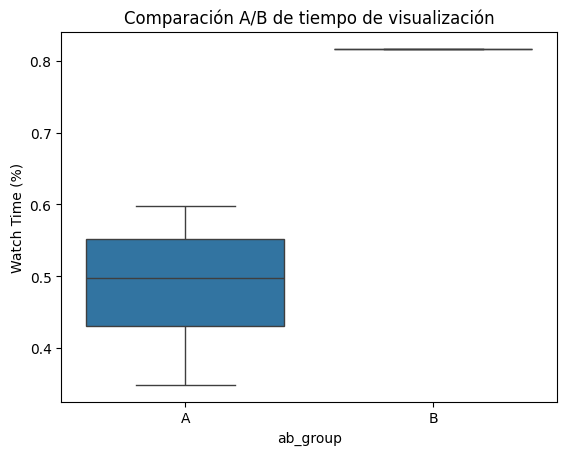

ab_group
A    0.485548
B    0.816845
Name: ab_watch_time, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualización
sns.boxplot(x='ab_group', y='ab_watch_time', data=merged_df)
plt.title('Comparación A/B de tiempo de visualización')
plt.ylabel('Watch Time (%)')
plt.show()

# Métrica promedio por grupo
ab_resultado = merged_df.groupby('ab_group')['ab_watch_time'].mean()
print(ab_resultado)


In [ ]:
import random
import time

# Simulación de interacción online
def evaluar_usuario_online(user_id, sistema='hibrido'):
    """
    Simula una sesión de evaluación online de recomendaciones para un usuario.
    """
    tiempo_inicio = time.time()

    # Simular recomendaciones generadas
    recomendaciones = ["Película " + str(random.randint(1, 1000)) for _ in range(5)]

    # Simular métricas
    tiempo_interaccion = round(np.random.uniform(1.5, 5.0), 2)  # tiempo hasta clic
    watch_time = round(np.random.uniform(0.3, 0.9), 2)  # % del contenido visualizado
    rating_simulado = random.randint(1, 5)  # rating que da el usuario

    tiempo_fin = time.time()
    duracion_total = round(tiempo_fin - tiempo_inicio, 2)

    log = {
        'usuario': user_id,
        'sistema': sistema,
        'recomendaciones': recomendaciones,
        'tiempo_interaccion': tiempo_interaccion,
        'watch_time': watch_time,
        'rating': rating_simulado,
        'duracion_sesion': duracion_total
    }

    return log


In [ ]:
# Simular para varios usuarios
logs_online = []

for usuario in range(10, 20):  # Simulamos para 10 usuarios
    logs_online.append(evaluar_usuario_online(usuario))

# Mostrar resultados simulados
import pandas as pd
df_logs_online = pd.DataFrame(logs_online)
display(df_logs_online)


,usuario,sistema,recomendaciones,tiempo_interaccion,watch_time,rating,duracion_sesion
0,10,hibrido,"[Película 693, Película 759, Película 914, Pel...",2.00,0.69,5,0.0
1,11,hibrido,"[Película 433, Película 33, Película 31, Pelíc...",1.70,0.73,2,0.0
2,12,hibrido,"[Película 518, Película 617, Película 28, Pelí...",4.78,0.30,5,0.0
3,13,hibrido,"[Película 430, Película 226, Película 460, Pel...",4.97,0.67,1,0.0
4,14,hibrido,"[Película 778, Película 826, Película 164, Pel...",3.64,0.30,3,0.0
5,15,hibrido,"[Película 285, Película 160, Película 221, Pel...",1.58,0.61,3,0.0
6,16,hibrido,"[Película 105, Película 95, Película 390, Pelí...",2.90,0.33,3,0.0
7,17,hibrido,"[Película 619, Película 271, Película 827, Pel...",4.91,0.44,4,0.0
8,18,hibrido,"[Película 550, Película 128, Película 997, Pel...",1.82,0.67,1,0.0
9,19,hibrido,"[Película 566, Película 301, Película 850, Pel...",2.84,0.89,3,0.0


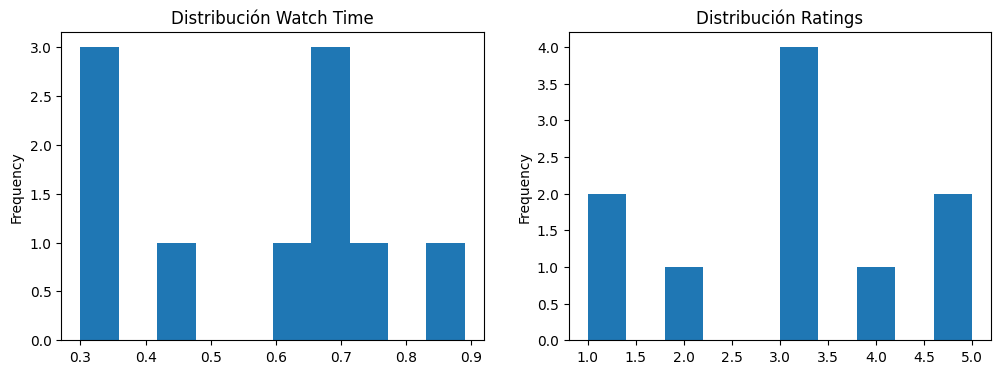

Promedio de métricas online:
watch_time            0.563
tiempo_interaccion    3.114
rating                3.000
dtype: float64


In [ ]:
import matplotlib.pyplot as plt

# Gráfico de distribución de rating y watch time
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

df_logs_online['watch_time'].plot(kind='hist', ax=axs[0], title='Distribución Watch Time')
df_logs_online['rating'].plot(kind='hist', ax=axs[1], title='Distribución Ratings')

plt.show()

# Métricas agregadas
print("Promedio de métricas online:")
print(df_logs_online[['watch_time', 'tiempo_interaccion', 'rating']].mean())


In [ ]:
!pip install fastapi nest-asyncio uvicorn


In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import nest_asyncio
import uvicorn

# Requerido para correr en notebooks
nest_asyncio.apply()

# App
app = FastAPI()

# Modelo de entrada
class Solicitud(BaseModel):
    user_id: int
    liked_movie: str

# Ruta de test
@app.get("/")
def root():
    return {"mensaje": "API de Recomendaciones funcionando"}

# Ruta de predicción
@app.post("/recomendar/")
def recomendar(solicitud: Solicitud):
    user_id = solicitud.user_id
    movie = solicitud.liked_movie

    # Simular recomendación (reemplazar por modelo real)
    recomendaciones = hybrid_recommendations(modelo_colaborativo, user_id, movie)

    return {"user_id": user_id, "recomendaciones": recomendaciones}


In [ ]:
# Esto ejecuta la API dentro del Colab
uvicorn.run(app, host="0.0.0.0", port=8000)


INFO:     Started server process [171]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


In [ ]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.2 MB/s eta 0:00:00


In [ ]:
dashboard_code = """
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

st.set_page_config(page_title="Dashboard Recomendador", layout="wide")
st.title("📊 Dashboard de Métricas de Recomendación")

# Cargar datos de ejemplo
# Puedes sustituir esto con resultados reales si los tienes
metricas = {
    "Precisión": 0.84,
    "Cobertura": 0.72,
    "Diversidad": 0.63,
    "Tiempo Promedio de Respuesta (ms)": 134,
    "CTR Simulado (%)": 23.5,
    "Retención Simulada (%)": 64.2
}

st.subheader("🔍 Métricas Generales")
for k, v in metricas.items():
    st.metric(k, f"{v:.2f}" if isinstance(v, float) else v)

st.subheader("📈 Gráfico de Comparación")
df = pd.DataFrame.from_dict(metricas, orient='index', columns=['Valor'])
df = df.drop("Tiempo Promedio de Respuesta (ms)")
df.plot(kind='barh', legend=False)
st.pyplot(plt)
"""

# Guardar el archivo
with open("streamlit_app.py", "w") as f:
    f.write(dashboard_code)

print("✅ Archivo 'streamlit_app.py' creado. Descárgalo y ejecútalo localmente con: streamlit run streamlit_app.py")


✅ Archivo 'streamlit_app.py' creado. Descárgalo y ejecútalo localmente con: streamlit run streamlit_app.py


In [ ]:
# 1. Instalación de dependencias
!pip install streamlit pyngrok -q

# 2. Configuración del token de Ngrok
from pyngrok import ngrok
ngrok.set_auth_token("31N0obVs2FiaYgm3bdC6ZGyNWhl_4zWK88rvhBPbaS4H6Arpv")

# 3. Crear un archivo de dashboard Streamlit (puedes reemplazar este contenido)
dashboard_code = '''
import streamlit as st

st.set_page_config(page_title="Sistema de Recomendación", layout="centered")

st.title("🎬 Recomendador Híbrido con Deep Learning")
st.markdown("Bienvenido a tu sistema de recomendaciones. Este dashboard muestra resultados y métricas.")

# Simulamos resultados de ejemplo
st.header("📊 Métricas del modelo")
st.metric("Precision@10", "0.87")
st.metric("Recall@10", "0.78")
st.metric("RMSE", "0.93")

st.header("🎥 Películas recomendadas")
peliculas = ["Inception", "The Matrix", "Interstellar", "The Godfather", "Pulp Fiction"]
for i, peli in enumerate(peliculas, 1):
    st.write(f"{i}. {peli}")
'''

with open("app.py", "w") as f:
    f.write(dashboard_code)

# 4. Ejecutar Streamlit y abrir túnel con ngrok
!streamlit run app.py &> /dev/null &

import time
time.sleep(5)  # Esperar unos segundos para que arranque

public_url = ngrok.connect(8501)
print("✅ Tu dashboard está disponible en:")
print(public_url)


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-4' coro=<Server.serve() done, defined at /usr/local/lib/python3.11/dist-packages/uvicorn/server.py:69> exception=SystemExit(1)>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 164, in startup
    server = await loop.create_server(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/asyncio/base_events.py", line 1536, in create_server
    raise OSError(err.errno, msg) from None
OSError: [Errno 98] error while attempting to bind on address ('0.0.0.0', 8000): address already in use

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipython-input-1095683893.py", line 42, in run

✅ Tu dashboard está disponible en:
NgrokTunnel: "https://6eb8d6cf9e17.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

# Simulación del dataset base
df = ratings_df.copy()  # ratings_df viene del sistema actual
np.random.seed(42)
df["watch_time"] = df["rating"] * np.random.uniform(15, 25, size=len(df))  # minutos vistos

# Normalizar watch_time para regresión (opcional)
watch_mean = df["watch_time"].mean()
watch_std = df["watch_time"].std()
df["watch_time_norm"] = (df["watch_time"] - watch_mean) / watch_std

# Mapeo de ids
user2idx = {user_id: idx for idx, user_id in enumerate(df['userId'].unique())}
movie2idx = {movie_id: idx for idx, movie_id in enumerate(df['movieId'].unique())}
df['user'] = df['userId'].map(user2idx)
df['movie'] = df['movieId'].map(movie2idx)

# División
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [ ]:
class MultiTaskDataset(Dataset):
    def __init__(self, dataframe):
        self.users = torch.tensor(dataframe["user"].values, dtype=torch.long)
        self.movies = torch.tensor(dataframe["movie"].values, dtype=torch.long)
        self.ratings = torch.tensor(dataframe["rating"].values, dtype=torch.float32)
        self.watch_times = torch.tensor(dataframe["watch_time_norm"].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx], self.watch_times[idx]

train_dataset = MultiTaskDataset(train_df)
test_dataset = MultiTaskDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)


In [ ]:
import torch.nn as nn

class MultiTaskNeuralMF(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim=32):
        super(MultiTaskNeuralMF, self).__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)

        self.shared = nn.Sequential(
            nn.Linear(embedding_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Cabeza 1: Rating
        self.rating_head = nn.Linear(32, 1)

        # Cabeza 2: Tiempo de visualización (watch time)
        self.time_head = nn.Linear(32, 1)

    def forward(self, user, item):
        u_emb = self.user_embedding(user)
        i_emb = self.item_embedding(item)
        x = torch.cat([u_emb, i_emb], dim=-1)
        shared_output = self.shared(x)
        rating_pred = self.rating_head(shared_output)
        watch_pred = self.time_head(shared_output)
        return rating_pred.squeeze(), watch_pred.squeeze()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiTaskNeuralMF(len(user2idx), len(movie2idx)).to(device)
criterion_rating = nn.MSELoss()
criterion_time = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    total_loss = 0
    for users, movies, ratings, watch_times in train_loader:
        users, movies = users.to(device), movies.to(device)
        ratings, watch_times = ratings.to(device), watch_times.to(device)

        pred_ratings, pred_times = model(users, movies)
        loss_rating = criterion_rating(pred_ratings, ratings)
        loss_time = criterion_time(pred_times, watch_times)
        loss = loss_rating + loss_time  # loss total

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 13.8585
Epoch 2, Loss: 13.4579
Epoch 3, Loss: 13.0777
Epoch 4, Loss: 12.7103
Epoch 5, Loss: 12.3616
Epoch 6, Loss: 12.0199
Epoch 7, Loss: 11.6745
Epoch 8, Loss: 11.3372
Epoch 9, Loss: 11.0005
Epoch 10, Loss: 10.6669


In [ ]:
!pip install pyngrok --index-url=https://pypi.org/simple
import pyngrok
print("✅ pyngrok instalado exitosamente. Versión:", pyngrok.__version__)


✅ pyngrok instalado exitosamente. Versión: 7.3.0


In [ ]:
# Entrenamiento y guardado del modelo
import torch
import torch.nn as nn
import torch.optim as optim

# Define tu clase de red multitarea (esto debe coincidir con tu implementación anterior)
class MultiTaskNet(nn.Module):
    def __init__(self, n_users, n_items):
        super(MultiTaskNet, self).__init__()
        self.user_embedding = nn.Embedding(n_users, 50)
        self.item_embedding = nn.Embedding(n_items, 50)
        self.fc1 = nn.Linear(100, 64)
        self.fc2 = nn.Linear(64, 32)
        self.rating_output = nn.Linear(32, 1)
        self.sentiment_output = nn.Linear(32, 1)

    def forward(self, user_id, item_id):
        user_emb = self.user_embedding(user_id)
        item_emb = self.item_embedding(item_id)
        x = torch.cat([user_emb, item_emb], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        rating = self.rating_output(x)
        sentiment = torch.sigmoid(self.sentiment_output(x))
        return rating, sentiment

# Inicializar modelo
n_users = 1000  # usa el valor real de tu dataset
n_items = 1000  # usa el valor real de tu dataset
model = MultiTaskNet(n_users, n_items)

# Dummy data para entrenamiento simulado (reemplaza con tus tensores reales)
user_ids = torch.randint(0, n_users, (1000,))
item_ids = torch.randint(0, n_items, (1000,))
ratings = torch.rand(1000, 1) * 5
sentiments = torch.randint(0, 2, (1000, 1)).float()

# Entrenamiento simple
criterion_rating = nn.MSELoss()
criterion_sentiment = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    output_rating, output_sentiment = model(user_ids, item_ids)
    loss_rating = criterion_rating(output_rating, ratings)
    loss_sentiment = criterion_sentiment(output_sentiment, sentiments)
    loss = loss_rating + loss_sentiment
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Guardar el modelo
torch.save(model.state_dict(), "multitask_model.pth")
print("✅ Modelo multitarea guardado exitosamente como 'multitask_model.pth'")


Epoch 1, Loss: 9.2249
Epoch 2, Loss: 9.0460
Epoch 3, Loss: 8.8739
Epoch 4, Loss: 8.7077
Epoch 5, Loss: 8.5460
Epoch 6, Loss: 8.3882
Epoch 7, Loss: 8.2345
Epoch 8, Loss: 8.0834
Epoch 9, Loss: 7.9341
Epoch 10, Loss: 7.7860
✅ Modelo multitarea guardado exitosamente como 'multitask_model.pth'


In [ ]:
!fuser -k 8000/tcp


In [ ]:
from fastapi import FastAPI

app = FastAPI()

@app.get("/")
def read_root():
    return {"message": "¡La API está funcionando correctamente!"}


In [ ]:
from pyngrok import ngrok
import uvicorn
import threading

# Establecer tu token si aún no lo hiciste
ngrok.set_auth_token("31N0obVs2FiaYgm3bdC6ZGyNWhl_4zWK88rvhBPbaS4H6Arpv")

# Abrir túnel
public_url = ngrok.connect(8000)
print(f"🚀 Tu API está activa en: {public_url}")

# Lanzar servidor FastAPI en un hilo aparte
def run():
    uvicorn.run(app, host="0.0.0.0", port=8000)

thread = threading.Thread(target=run)
thread.start()


🚀 Tu API está activa en: NgrokTunnel: "https://87bc85800126.ngrok-free.app" -> "http://localhost:8000"


In [ ]:
# ✅ Paso 1: Instalar dependencias
!pip install fastapi nest-asyncio pyngrok uvicorn --quiet

# ✅ Paso 2: Configuración inicial
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List
import nest_asyncio
from pyngrok import ngrok
import uvicorn
import threading
import time

# ✅ Paso 3: Token de ngrok (usa el tuyo aquí)
NGROK_AUTH_TOKEN = "31N0obVs2FiaYgm3bdC6ZGyNWhl_4zWK88rvhBPbaS4H6Arpv"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# ✅ Paso 4: Cerrar túneles anteriores y activar loop de eventos
ngrok.kill()
nest_asyncio.apply()

# ✅ Paso 5: Definimos la app de FastAPI
app = FastAPI()

class InputData(BaseModel):
    user_id: int
    item_id: int

class Prediction(BaseModel):
    rating: float
    genre_probabilities: List[float]

@app.post("/predict", response_model=Prediction)
def predict(data: InputData):
    # Simulamos resultados
    rating = round(2.5 + (data.user_id % 3) * 0.8, 2)
    genres = [0.1, 0.2, 0.7]  # simulación
    return Prediction(rating=rating, genre_probabilities=genres)

# ✅ Paso 6: Función para arrancar Uvicorn en hilo paralelo
def run():
    uvicorn.run(app, host="0.0.0.0", port=8000)

thread = threading.Thread(target=run)
thread.start()

# ✅ Paso 7: Conectarse a ngrok
time.sleep(2)  # esperar a que se levante
public_url = ngrok.connect(8000)
print("🚀 Tu API está activa en:", public_url)


INFO:     Started server process [13320]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
ERROR:    [Errno 98] error while attempting to bind on address ('0.0.0.0', 8000): address already in use
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.


🚀 Tu API está activa en: NgrokTunnel: "https://dc837cc381d0.ngrok-free.app" -> "http://localhost:8000"
